In [202]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
from glob import glob

In [203]:
dir_plots = './plots'
dir_file = './data/sharew8_all/'
rel_data_dir_easy = './data/sharew8_easy/'

all_files = glob(f"{dir_file}*.dta")
easy_files = glob(f"{rel_data_dir_easy}*.dta")

df_easy = pd.read_stata(easy_files[0])
df_easy = df_easy[df_easy['wave'] == 8]
df_acc_hr = pd.read_stata(os.path.join(dir_file, 'sharew8_rel8-0-0_gv_accelerometer_hour.dta'))
df_acc_hr.drop(df_acc_hr.loc[df_acc_hr['GGIR_N_valid_hours'] < 0.75].index, inplace=True)
df_acc_hr.drop(df_acc_hr.loc[df_acc_hr['measurementday'] > 7].index, inplace=True)
df_ph = pd.read_stata(os.path.join(dir_file, 'sharew8_rel8-0-0_ph.dta'))
df_br = pd.read_stata(os.path.join(dir_file, 'sharew8_rel8-0-0_br.dta'))


In [204]:
df1 = df_acc_hr[["mergeid", "measurementday", "weekday", "GGIR_mean_ENMO_hour", "hour", "OxCGRT_stay_at_home", "OxCGRT_stringency_index"]].copy()
df2 = df_ph[["mergeid", 'ph006d2', 'ph006d5', 'ph006d20', 'ph087d2', 'ph087d3']].copy()
df3 = df_br[["mergeid", 'br015_', 'br016_']].copy()
df4 = df_easy[["mergeid", "female", "age", "bmi"]].copy()

In [205]:
def get_common_columns(df1, df2, merge_on=['mergeid']):
    common = df1.columns.difference(df2.columns).tolist()
    common.extend(merge_on)
    return common

In [206]:
df = df1.copy()
df = pd.merge(left=df, left_on=['mergeid'], right=df2[get_common_columns(df2, df)], right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df3[get_common_columns(df3, df)], right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df4[get_common_columns(df4, df)], right_on=['mergeid'], how='left')

In [207]:
def map_selected_num(df, columns:list[str]):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].map({
            'Selected': 1,
            'Not selected': 0,
            "Don't know": -1,
            'Refusal': -1,
            1:1,
            0:0,
            -1:-1,
        })
    return df
df = map_selected_num(df, ['ph006d2', 'ph006d5', 'ph006d20', 'ph087d2', 'ph087d3'])

def map_bmi_num(df, columns: list[str] = ['bmi']):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].replace({
            '-15. no information': -1,
            '-13. not asked in this wave': -1,
            "-12. don't know / refusal": -1,
            '-3. implausible value/suspected wrong': -1,
        })
        df[c] = df[c].astype(float)
    return df

df = map_bmi_num(df)

def map_freq_num(df, columns:list[str]):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].replace({
            'More than once a week': 1,
            'Once a week': 2,
            'One to three times a month': 3,
            'Hardly ever, or never': 4,
            "Don't know": -1,
            'Refusal' : -1,
        })
        df[c] = df[c].astype(float)
    return df
df = map_freq_num(df, ['br015_', 'br016_']) 

df['female'] = pd.to_numeric(df['female'].replace({'1. female': 1, '0. male': 0}))
df.loc[:, 'age'] = df.replace({'-15. no information': -1})
df.loc[:, 'age'] = df['age'].astype(float)


In [208]:
df['Hypertension'] = pd.to_numeric(df['ph006d2'])
df['Diabetes'] = pd.to_numeric(df['ph006d5'])
df['OA'] = np.where(((df['ph006d20'] == 1) & (df['ph087d2'] == 1)) | ((df['ph006d20'] == 1) & (df['ph087d3'] == 1)), int(1), int(0))

In [209]:
df['d1'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 0) & (df['OA'] == 0), int(1), int(0))
df['d2'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 1) & (df['OA'] == 0), int(1), int(0))
df['d3'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 0) & (df['OA'] == 1), int(1), int(0))
df['d4'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 1) & (df['OA'] == 0), int(1), int(0))
df['d5'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 0) & (df['OA'] == 1), int(1), int(0))
df['d6'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 1) & (df['OA'] == 1), int(1), int(0))
df['d7'] = np.where((df['Hypertension'] == 1) & (df['Diabetes'] == 1) & (df['OA'] == 1), int(1), int(0))
df['control'] = np.where((df['Hypertension'] == 0) & (df['Diabetes'] == 0) & (df['OA'] == 0), int(1), int(0))
df['disease']  = df[['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'control',]].apply(lambda x: x.idxmax(), axis=1)

In [210]:
df['activity'] = 2*(4-df['br015_']) + (4-df['br016_'])

thresholds: https://doi.org/10.1371/journal.pone.0164045.s002

light-intensity physical activities (e.g. standing and light walking, household activities)


In [211]:
sed_t = 4.5 #mean = 3.6
LPA_t = 60 #mean household = 5.9-22.4; mean = 58.5 (self-paced-free-living walk)

conditions = [
    (df["GGIR_mean_ENMO_hour"] <= sed_t),
    (df["GGIR_mean_ENMO_hour"] > sed_t) & (df["GGIR_mean_ENMO_hour"] <= LPA_t),
    (df["GGIR_mean_ENMO_hour"] > LPA_t)
]

behaviour = ["SED", "LPA", "MVPA"]
#behaviour = [1,2,3,4]
df["behaviour"] = np.select(conditions, behaviour)
df["behaviour"].fillna(0)

0         SED
1         SED
2         LPA
3         SED
4         SED
         ... 
133337    LPA
133338    LPA
133339    LPA
133340    LPA
133341    SED
Name: behaviour, Length: 133342, dtype: object

In [212]:
behaviour = (
    df.groupby('disease')
.behaviour
.value_counts(normalize=True)
.unstack()
)

Heatmap

    positive correlation -> 1 (blue)
    negative correltation -> 0 (red)

<AxesSubplot:xlabel='behaviour', ylabel='disease'>

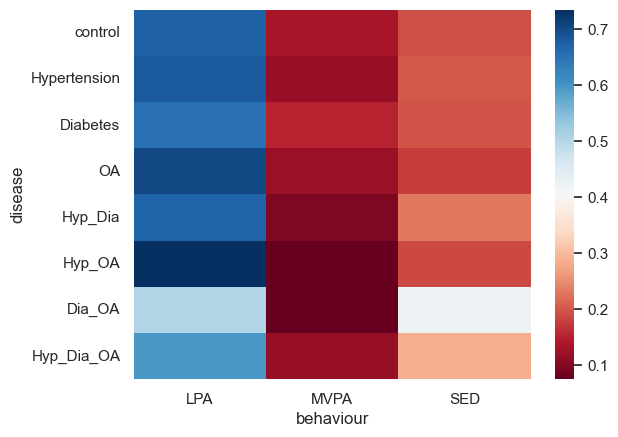

In [213]:
labels = ["control", "Hypertension", "Diabetes", "OA", "Hyp_Dia", "Hyp_OA", "Dia_OA", "Hyp_Dia_OA"]
sns.heatmap(behaviour, 
            cmap='RdBu', 
            yticklabels=labels
            )
#sns.heatmap(behaviour, cmap='RdBu', annot=True, fmt=".2f", annot_kws={'fontsize': 8})

In [214]:
'''
WHO recommendation:
150 min in MPA per week or, ~ MPA count = 3 (180 min)
75 min VPA per week , ~ VPA count = 1 (60 min)
'''

resp_be = (
    df.groupby(['mergeid', 'disease'])
.behaviour
.value_counts()
.unstack()
)

resp_be["WHO_recom"] = np.where(resp_be['MVPA'] == 3, int(1), int(0))
resp_be.head()


,behaviour,LPA,MVPA,SED,WHO_recom
mergeid,disease,,,,
Bf-031257-01,control,124.0,1.0,38.0,0
Bf-043946-02,d1,104.0,2.0,53.0,0
Bf-073169-01,d1,131.0,3.0,34.0,1
Bf-227520-04,d1,36.0,NaN,12.0,0
Bf-286437-02,d1,108.0,NaN,12.0,0


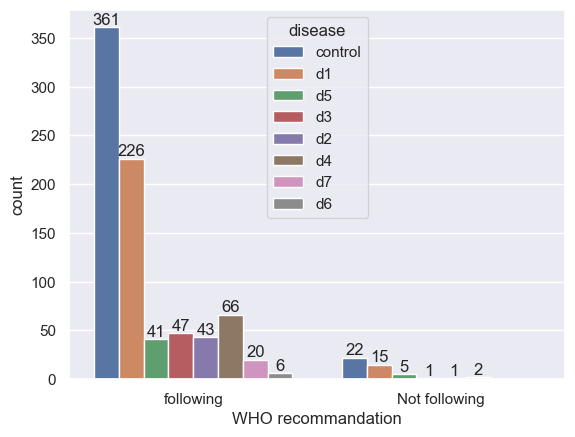

In [215]:
plt.figure()
ax = sns.countplot(data=resp_be, x="WHO_recom", hue=resp_be.index.get_level_values(1))
for container in ax.containers:
    ax.bar_label(container)
ax.set_xticklabels(["following", "Not following"])
ax.set_xlabel("WHO recommandation")
plt.show()

c:\Users\mjbur\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\mjbur\AppData\Local\Temp\ipykernel_22796\1312633274.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([" ", " ", "following"," ", "Not following"])


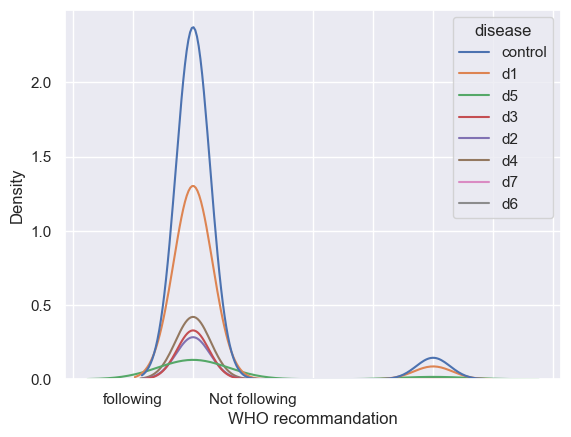

In [216]:
plt.figure()
ax = sns.kdeplot(data=resp_be, x="WHO_recom", hue=resp_be.index.get_level_values(1))
for container in ax.containers:
    ax.bar_label(container)
ax.set_xticklabels([" ", " ", "following"," ", "Not following"])
ax.set_xlabel("WHO recommandation")
plt.show()

<AxesSubplot:>

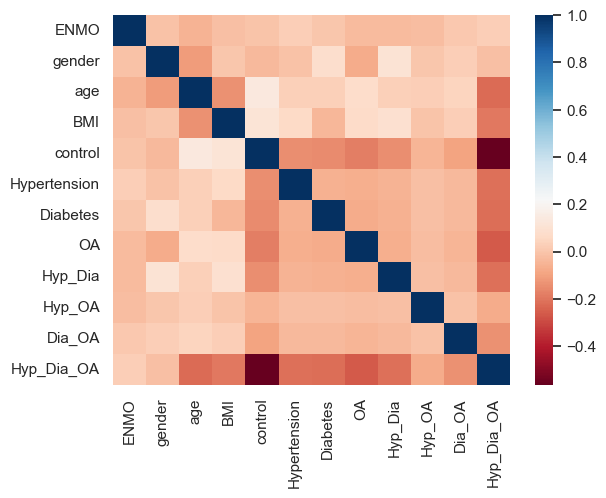

In [217]:
labels = ["ENMO", "gender", "age", "BMI", "control", "Hypertension", "Diabetes", "OA", "Hyp_Dia", "Hyp_OA", "Dia_OA", "Hyp_Dia_OA"]
df_corr = df[["GGIR_mean_ENMO_hour", "female", "age", "bmi", "d1", "d2", "d3", "d4", "d5", "d6", "d7", "control"]].copy()
sns.heatmap(df_corr.corr(), cmap='RdBu',xticklabels=labels, yticklabels=labels)


In [218]:
import statsmodels.api as sm 
from statsmodels.formula.api import ols

df.loc[:, 'behaviour'] = df.replace({'SED': 1,
                                     'LPA': 2,
                                     'MVPA': 3,
                                     })

YVar = df["behaviour"]

XVar1 = df[["d1", "d2", "d3", "d4", "d5", "d6", "d7", "age", "female", "bmi"]]
XVar1 = sm.add_constant(XVar1)

model = sm.OLS(YVar, XVar1).fit()
print(model.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:              behaviour   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
No. Observations:              133342   F-statistic:                     98.71
Covariance Type:            nonrobust   Prob (F-statistic):          6.75e-205
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2773      0.016    145.468      0.000       2.247       2.308
d1             0.0019      0.004      0.507      0.612      -0.006       0.009
d2             0.0384      0.007      5.366      0.000       0.024       0.052
d3             0.0195      0.007      2.835      0.005       0.006       0.033
d4            -0.0430      0.006     -7.133      0.000      -0.055      -0.031
d5            -0.0238      0.007     -3.279      0.0

In [219]:
df.loc[:, 'behaviour'] = df.replace({'SED': 1,
                                     'LPA': 2,
                                     'MVPA': 3,
                                     })

XVar1 = df[["d1", "age", "female", "bmi"]]
XVar1 = sm.add_constant(XVar1)

model = sm.OLS(YVar, XVar1).fit()
print(model.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:              behaviour   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
No. Observations:              133342   F-statistic:                     159.6
Covariance Type:            nonrobust   Prob (F-statistic):          1.60e-136
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2988      0.015    149.392      0.000       2.269       2.329
d1             0.0102      0.003      2.947      0.003       0.003       0.017
age           -0.0041      0.000    -22.937      0.000      -0.004      -0.004
female        -0.0009      0.003     -0.291      0.771      -0.007       0.005
bmi           -0.0037      0.000    -13.754      0.000      -0.004      -0.003

Notes:
[1] Standard Errors assume that the covarian

In [220]:
df.loc[:, 'behaviour'] = df.replace({'SED': 1,
                                     'LPA': 2,
                                     'MVPA': 3,
                                     })

XVar1 = df[["d2", "age", "female", "bmi"]]
XVar1 = sm.add_constant(XVar1)

model = sm.OLS(YVar, XVar1).fit()
print(model.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:              behaviour   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
No. Observations:              133342   F-statistic:                     168.6
Covariance Type:            nonrobust   Prob (F-statistic):          2.64e-144
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2973      0.015    150.198      0.000       2.267       2.327
d2             0.0462      0.007      6.682      0.000       0.033       0.060
age           -0.0040      0.000    -22.992      0.000      -0.004      -0.004
female        -0.0009      0.003     -0.288      0.774      -0.007       0.005
bmi           -0.0037      0.000    -13.892      0.000      -0.004      -0.003

Notes:
[1] Standard Errors assume that the covarian

In [221]:
df.loc[:, 'behaviour'] = df.replace({'SED': 1,
                                     'LPA': 2,
                                     'MVPA': 3,
                                     })

XVar1 = df[["d3", "age", "female", "bmi"]]
XVar1 = sm.add_constant(XVar1)

model = sm.OLS(YVar, XVar1).fit()
print(model.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:              behaviour   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
No. Observations:              133342   F-statistic:                     161.2
Covariance Type:            nonrobust   Prob (F-statistic):          6.93e-138
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2935      0.015    150.029      0.000       2.264       2.323
d3             0.0257      0.007      3.871      0.000       0.013       0.039
age           -0.0040      0.000    -22.876      0.000      -0.004      -0.004
female        -0.0021      0.003     -0.664      0.507      -0.008       0.004
bmi           -0.0035      0.000    -13.344      0.000      -0.004      -0.003

Notes:
[1] Standard Errors assume that the covarian

In [222]:
df.loc[:, 'behaviour'] = df.replace({'SED': 1,
                                     'LPA': 2,
                                     'MVPA': 3,
                                     })

XVar1 = df[["d4", "age", "female", "bmi"]]
XVar1 = sm.add_constant(XVar1)

model = sm.OLS(YVar, XVar1).fit()
print(model.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:              behaviour   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
No. Observations:              133342   F-statistic:                     170.7
Covariance Type:            nonrobust   Prob (F-statistic):          4.19e-146
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2866      0.015    149.314      0.000       2.257       2.317
d4            -0.0416      0.006     -7.277      0.000      -0.053      -0.030
age           -0.0039      0.000    -22.104      0.000      -0.004      -0.004
female        -0.0025      0.003     -0.806      0.420      -0.009       0.004
bmi           -0.0034      0.000    -12.874      0.000      -0.004      -0.003

Notes:
[1] Standard Errors assume that the covarian

In [223]:
df.loc[:, 'behaviour'] = df.replace({'SED': 1,
                                     'LPA': 2,
                                     'MVPA': 3,
                                     })

XVar1 = df[["d5", "age", "female", "bmi"]]
XVar1 = sm.add_constant(XVar1)

model = sm.OLS(YVar, XVar1).fit()
print(model.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:              behaviour   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
No. Observations:              133342   F-statistic:                     159.5
Covariance Type:            nonrobust   Prob (F-statistic):          2.11e-136
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2899      0.015    149.269      0.000       2.260       2.320
d5            -0.0199      0.007     -2.852      0.004      -0.034      -0.006
age           -0.0040      0.000    -22.540      0.000      -0.004      -0.004
female     -8.404e-05      0.003     -0.027      0.979      -0.006       0.006
bmi           -0.0035      0.000    -13.129      0.000      -0.004      -0.003

Notes:
[1] Standard Errors assume that the covarian

In [224]:
df.loc[:, 'behaviour'] = df.replace({'SED': 1,
                                     'LPA': 2,
                                     'MVPA': 3,
                                     })

XVar1 = df[["d6", "age", "female", "bmi"]]
XVar1 = sm.add_constant(XVar1)

model = sm.OLS(YVar, XVar1).fit()
print(model.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:              behaviour   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
No. Observations:              133342   F-statistic:                     202.6
Covariance Type:            nonrobust   Prob (F-statistic):          1.42e-173
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2902      0.015    149.892      0.000       2.260       2.320
d6            -0.2577      0.019    -13.413      0.000      -0.295      -0.220
age           -0.0039      0.000    -22.370      0.000      -0.004      -0.004
female        -0.0008      0.003     -0.250      0.803      -0.007       0.005
bmi           -0.0036      0.000    -13.468      0.000      -0.004      -0.003

Notes:
[1] Standard Errors assume that the covarian

In [225]:
df.loc[:, 'behaviour'] = df.replace({'SED': 1,
                                     'LPA': 2,
                                     'MVPA': 3,
                                     })

XVar1 = df[["d7", "age", "female", "bmi"]]
XVar1 = sm.add_constant(XVar1)

model = sm.OLS(YVar, XVar1).fit()
print(model.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:              behaviour   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
No. Observations:              133342   F-statistic:                     171.5
Covariance Type:            nonrobust   Prob (F-statistic):          8.86e-147
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2884      0.015    149.573      0.000       2.258       2.318
d7            -0.0768      0.010     -7.488      0.000      -0.097      -0.057
age           -0.0039      0.000    -22.329      0.000      -0.004      -0.004
female        -0.0003      0.003     -0.099      0.921      -0.006       0.006
bmi           -0.0035      0.000    -13.242      0.000      -0.004      -0.003

Notes:
[1] Standard Errors assume that the covarian

In [226]:
df.loc[:, 'behaviour'] = df.replace({'SED': 1,
                                     'LPA': 2,
                                     'MVPA': 3,
                                     })

XVar1 = df[["control", "age", "female", "bmi"]]
XVar1 = sm.add_constant(XVar1)

model = sm.OLS(YVar, XVar1).fit()
print(model.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:              behaviour   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
No. Observations:              133342   F-statistic:                     158.8
Covariance Type:            nonrobust   Prob (F-statistic):          8.40e-136
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2784      0.017    136.946      0.000       2.246       2.311
control        0.0076      0.003      2.314      0.021       0.001       0.014
age           -0.0039      0.000    -21.350      0.000      -0.004      -0.004
female        -0.0007      0.003     -0.232      0.817      -0.007       0.005
bmi           -0.0034      0.000    -12.558      0.000      -0.004      -0.003

Notes:
[1] Standard Errors assume that the covarian